# 栄養問題

- 定数
  - $F$: 商品の集合
  - $N$: 栄養素の集合
  - $a_i$: 栄養素 $i$ の 1 日の摂取量の下限
  - $b_i$: 栄養素 $i$ の 1 日の摂取量の上限
  - $c_j$: 商品 $j$ の価格
  - $n_{ij}$: 商品 $j$ に含まれる栄養素 $i$ の量
- 決定変数
  - $x_j \in \mathbb{R}_{\geq 0}$: 商品 $j$ を購入する個数

\begin{align}
&\text{minimize} & \sum_{j \in F} c_j x_j \\
&\text{s.t.} & a_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i \ (\forall i \in N) \\
& & x_j \geq 0 \ (\forall j \in F)
\end{align}

In [1]:
import cvxpy as cp
import pandas as pd

(CVXPY) Nov 10 03:45:35 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 10 03:45:35 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


## 実行不能のケース

\begin{align}
&\text{maximize} & x_1 + x_2 \\
&\text{s.t.} & x_1 - x_2 \leq -1 \\
& & - x_1 + x_2 \leq -1 \\
& & x_1, x_2 \geq 0
\end{align}

In [2]:
var = cp.Variable(2, nonneg=True)
x1 = var[0]
x2 = var[1]

var

Variable((2,), var1, nonneg=True)

In [3]:
constraints = []
constraints.append(x1 - x2 <= -1)
constraints.append(-x1 + x2 <= -1)

constraints

[Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

In [4]:
objective = x1 + x2

objective

Expression(AFFINE, NONNEGATIVE, ())

In [5]:
problem = cp.Problem(cp.Maximize(objective), constraints)

problem

Problem(Maximize(Expression(AFFINE, NONNEGATIVE, ())), [Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ()))])

In [6]:
result = problem.solve(verbose=True)

result

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:35 PM: Your problem has 2 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 10 03:45:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 03:45:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:35 PM: Compiling problem (target solver=CLARABEL).
(

-inf

In [7]:
problem.status

'infeasible'

## 非有界のケース

\begin{align}
&\text{maximize} & x_1 + x_2 \\
&\text{s.t.} & x_1 - x_2 \geq -1 \\
& & - x_1 + x_2 \geq -1 \\
& & x_1, x_2 \geq 0
\end{align}

In [8]:
var = cp.Variable(2, nonneg=True)
x1 = var[0]
x2 = var[1]

var

Variable((2,), var75, nonneg=True)

In [9]:
constraints = []
constraints.append(x1 - x2 >= -1)
constraints.append(-x1 + x2 >= -1)

constraints

[Inequality(Constant(CONSTANT, NONPOSITIVE, ())),
 Inequality(Constant(CONSTANT, NONPOSITIVE, ()))]

In [10]:
objective = x1 + x2

objective

Expression(AFFINE, NONNEGATIVE, ())

In [11]:
problem = cp.Problem(cp.Maximize(objective), constraints)

problem

Problem(Maximize(Expression(AFFINE, NONNEGATIVE, ())), [Inequality(Constant(CONSTANT, NONPOSITIVE, ())), Inequality(Constant(CONSTANT, NONPOSITIVE, ()))])

In [12]:
result = problem.solve(verbose=True)

result

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:35 PM: Your problem has 2 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 10 03:45:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 03:45:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:35 PM: Compiling problem (target solver=CLARABEL).
(

inf

In [13]:
problem.status

'unbounded'

In [14]:
x1.value

## 実行不可能性の対処法(制約の逸脱を許すモデル化)

栄養素摂取量制約の逸脱を許すために摂取量の不足分と超過分を表す決定変数を用意する. 

- $d_i \in \mathbb{R}_{\geq 0}$: 栄養素 $i$ に対する不足変数
- $s_i \in \mathbb{R}_{\geq 0}$: 栄養素 $i$ に対する超過変数

制約を以下のように変更する. 

$$
a_i - d_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i + s_i \ (\forall i \in N)
$$

目的関数には以下の逸脱ペナルティを追加する($M$ は十分大きな定数). 

$$
\text{minimize} \sum_{j \in F} c_j x_j + M \sum_{i \in N} (d_i + s_i)
$$

結果, 以下のような定式化になる. 

\begin{align}
&\text{minimize} & \sum_{j \in F} c_j x_j + M \sum_{i \in N} (d_i + s_i) \\
&\text{s.t.} & a_i - d_i \leq \sum_{j \in F} n_{ij} x_j \leq b_i + s_i \ (\forall i \in N) \\
& & x_j \geq 0 \ (\forall j \in F)
\end{align}

In [15]:
# https://scmopt.github.io/manual/15mypulp.html#multidict%E9%96%A2%E6%95%B0

def multidict(d: dict):
  ret = [list(d.keys())]
  for k, arr in d.items():
    if type(arr) is not list:
      arr = [arr]
    append_num = (1 + len(arr)) - len(ret)
    if append_num > 0:
      ret += [{} for _ in range(append_num)]

    for i, val in enumerate(arr):
      ret[i+1][k] = val

  return ret

I,d = multidict({1:80, 2:270, 3:250 , 4:160, 5:180})
J,M,N = multidict({1:[500,600], 2:[800,500], 3:[500,100]})
print(I,d)
print(J,M,N)

[1, 2, 3, 4, 5] {1: 80, 2: 270, 3: 250, 4: 160, 5: 180}
[1, 2, 3] {1: 500, 2: 800, 3: 500} {1: 600, 2: 500, 3: 100}


In [16]:
F, c, n = multidict(
    {
        "CQPounder": [
            360,
            {
                "Cal": 556,
                "Carbo": 39,
                "Protein": 30,
                "VitA": 147,
                "VitC": 10,
                "Calc": 221,
                "Iron": 2.4,
            },
        ],
        "Big M": [
            320,
            {
                "Cal": 556,
                "Carbo": 46,
                "Protein": 26,
                "VitA": 97,
                "VitC": 9,
                "Calc": 142,
                "Iron": 2.4,
            },
        ],
        "FFilet": [
            270,
            {
                "Cal": 356,
                "Carbo": 42,
                "Protein": 14,
                "VitA": 28,
                "VitC": 1,
                "Calc": 76,
                "Iron": 0.7,
            },
        ],
        "Chicken": [
            290,
            {
                "Cal": 431,
                "Carbo": 45,
                "Protein": 20,
                "VitA": 9,
                "VitC": 2,
                "Calc": 37,
                "Iron": 0.9,
            },
        ],
        "Fries": [
            190,
            {
                "Cal": 249,
                "Carbo": 30,
                "Protein": 3,
                "VitA": 0,
                "VitC": 5,
                "Calc": 7,
                "Iron": 0.6,
            },
        ],
        "Milk": [
            170,
            {
                "Cal": 138,
                "Carbo": 10,
                "Protein": 7,
                "VitA": 80,
                "VitC": 2,
                "Calc": 227,
                "Iron": 0,
            },
        ],
        "VegJuice": [
            100,
            {
                "Cal": 69,
                "Carbo": 17,
                "Protein": 1,
                "VitA": 750,
                "VitC": 2,
                "Calc": 18,
                "Iron": 0,
            },
        ],
    }
)

In [17]:
N, a, b = multidict(
    {
        "Cal": [2000, 3000],
        "Carbo": [300, 375],
        "Protein": [50, 60],
        "VitA": [500, 750],
        "VitC": [85, 100],
        "Calc": [660, 900],
        "Iron": [6.0, 7.5],
    }
)

In [18]:
x, s, d = {}, {}, {}
for j in F:
    x[j] = cp.Variable(nonneg=True)
for i in N:
    s[i] = cp.Variable(nonneg=True)
    d[i] = cp.Variable(nonneg=True)

In [19]:
constraints = []
constraints += [sum(n[j][i] * x[j] for j in F) >= a[i] - d[i] for i in N]
constraints += [sum(n[j][i] * x[j] for j in F) <= b[i] - s[i] for i in N]

In [20]:
M = cp.Parameter(value=9999)
objective = sum(c[j] * x[j] for j in F) + M * sum(d[i] + s[i] for i in N)

In [21]:
problem = cp.Problem(cp.Minimize(objective), constraints)

In [22]:
result = problem.solve(verbose=True)

result

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:35 PM: Your problem has 21 variables, 14 constraints, and 1 parameters.
(CVXPY) Nov 10 03:45:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:35 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Nov 10 03:45:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Nov 10 03:45:35 P

np.float64(265119.1876290786)

In [23]:
for i in N:
    info = "正常"
    if sum(n[j][i] * x[j].value for j in F) < a[i] - d[i].value or sum(n[j][i] * x[j].value for j in F) > b[i] - s[i].value:
        info = "違反"
    print(f"[{info}]栄養素 {i:<7} 摂取量 {sum(n[j][i] * x[j].value for j in F):>7.2f}, 正常範囲: [{a[i]:>6.1f}, {b[i]:>6.1f}]")

[正常]栄養素 Cal     摂取量 3000.00, 正常範囲: [2000.0, 3000.0]
[正常]栄養素 Carbo   摂取量  350.74, 正常範囲: [ 300.0,  375.0]
[正常]栄養素 Protein 摂取量   50.00, 正常範囲: [  50.0,   60.0]
[正常]栄養素 VitA    摂取量  750.00, 正常範囲: [ 500.0,  750.0]
[違反]栄養素 VitC    摂取量   58.73, 正常範囲: [  85.0,  100.0]
[正常]栄養素 Calc    摂取量  660.00, 正常範囲: [ 660.0,  900.0]
[正常]栄養素 Iron    摂取量    6.29, 正常範囲: [   6.0,    7.5]


In [24]:
sum(c[j] * x[j] for j in F).value

np.float64(2485.5814440224326)

In [25]:
objective.value

np.float64(265119.1876290786)

# 逸脱最小化

整数変数の連続変数化, 制約の逸脱をコスト関数化. 

In [26]:
x, s, d = {}, {}, {}
for j in F:
    x[j] = cp.Variable(nonneg=True)
for i in N:
    s[i] = cp.Variable(nonneg=True)
    d[i] = cp.Variable(nonneg=True)

In [27]:
constraints = []
constraints += [sum(n[j][i] * x[j] for j in F) >= a[i] - d[i] for i in N]
constraints += [sum(n[j][i] * x[j] for j in F) <= b[i] - s[i] for i in N]

In [28]:
M = 9999

svec = cp.Variable(len(N), nonneg=True)
dvec = cp.Variable(len(N), nonneg=True)

for idx, i in enumerate(N):
    constraints.append(svec[idx] == s[i])
    constraints.append(dvec[idx] == d[i])

# objective = sum(c[j] * x[j] for j in F) + M * sum(d[i] * d[i] + s[i] * s[i] for i in N)
objective = sum(c[j] * x[j] for j in F) + M * (cp.sum_squares(svec) + cp.sum_squares(dvec))

In [29]:
problem = cp.Problem(cp.Minimize(objective), constraints)

In [30]:
# result = problem.solve(verbose=True)
result = problem.solve(verbose=True, solver=cp.CLARABEL)

result

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:35 PM: Your problem has 35 variables, 28 constraints, and 0 parameters.
(CVXPY) Nov 10 03:45:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 03:45:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:35 PM: Compiling problem (target solver=CLARABEL).

np.float64(6897718.082394719)

In [31]:
for i in N:
    info = "正常"
    if sum(n[j][i] * x[j].value for j in F) < a[i] or sum(n[j][i] * x[j].value for j in F) > b[i]:
        info = "違反"
    print(f"[{info}]栄養素 {i:<7} 摂取量 {sum(n[j][i] * x[j].value for j in F):>7.2f}, 正常範囲: [{a[i]:>6.1f}, {b[i]:>6.1f}]")

[正常]栄養素 Cal     摂取量 3000.00, 正常範囲: [2000.0, 3000.0]
[正常]栄養素 Carbo   摂取量  351.05, 正常範囲: [ 300.0,  375.0]
[違反]栄養素 Protein 摂取量   49.76, 正常範囲: [  50.0,   60.0]
[正常]栄養素 VitA    摂取量  750.00, 正常範囲: [ 500.0,  750.0]
[違反]栄養素 VitC    摂取量   58.74, 正常範囲: [  85.0,  100.0]
[違反]栄養素 Calc    摂取量  659.91, 正常範囲: [ 660.0,  900.0]
[正常]栄養素 Iron    摂取量    6.27, 正常範囲: [   6.0,    7.5]


In [32]:
sum(c[j] * x[j] for j in F).value

np.float64(2487.240393581563)

# 既約不整合部分系

既約不整合部分系 (irreducible Inconsistent Subsystem: IIS)

- 実行不可能
- 上下限もしくは制約を1つ除くと実行可能になる

# 混合問題

- 定数
  - $I$: 原料の集合
  - $K$: 成分の集合
  - $p_i$: 原料 $i$ の価格
  - $a_{ik}$: 原料 $i$ に含まれる成分 $k$ の比率
  - $LB_k$: 製品に含まれる成分 $k$ の比率の下限
  - $\varepsilon$: 誤差の 2 乗和の上限
- 決定変数
  - $x_i$: 原料 $i$ の含有比率

\begin{align}
&\text{minimize} & \sum_{i \in I} p_i x_i \\
&\text{s.t.} & \sum_{i \in I} x_i = 1 \\
& & \sqrt{\varepsilon^2 \sum_{i \in I} x_i^2} \leq -LB_k + \sum_{i \in I} a_{ik} x_i \quad (\forall k \in K) \\
& & x_i \geq 0 \quad (\forall i \in I)
\end{align}

In [33]:
def make_data():
    a = {
        (1, 1): 0.25,
        (1, 2): 0.15,
        (1, 3): 0.2,
        (2, 1): 0.3,
        (2, 2): 0.3,
        (2, 3): 0.1,
        (3, 1): 0.15,
        (3, 2): 0.65,
        (3, 3): 0.05,
        (4, 1): 0.1,
        (4, 2): 0.05,
        (4, 3): 0.8,
    }
    epsilon = 0.01
    I, p = multidict({1: 5, 2: 6, 3: 8, 4: 20})
    K, LB = multidict({1: 0.2, 2: 0.3, 3: 0.2})
    return I, K, a, p, epsilon, LB

In [34]:
def prodmix(I, K, a, p, epsilon, LB):
    """prodmix:  robust production planning using soco
    Parameters:
        I - set of materials
        K - set of components
        a[i][k] -  coef. matrix
        p[i] - price of material i
        LB[k] - amount needed for k
    Returns a model, ready to be solved.
    """

    xvar = cp.Variable(len(I), nonneg=True)
    x = {i: xvar[i-1] for i in I}

    constraints = []
    constraints.append(sum(x[i] for i in I) == 1)

    for k in K:
        rhs = cp.Variable()
        if epsilon != 0:
            constraints.append(epsilon * rhs == -LB[k] + sum(a[i,k] * x[i] for i in I))
            constraints.append(cp.SOC(rhs, xvar)) # ||x||^2 <= rhs^2
        else:
            constraints.append(0 <= -LB[k] + sum(a[i,k] * x[i] for i in I))

    objective = sum(p[i] * x[i] for i in I)
    problem = cp.Problem(cp.Minimize(objective), constraints)

    return problem

In [35]:
I, K, a, p, epsilon, LB = make_data()
obj_list = []
for i in range(5):
    epsilon = i * 0.01
    model = prodmix(I, K, a, p, epsilon, LB)
    model.solve(verbose=False)
    print(f"obj: {model.objective.value}")
    obj_list.append(model.objective.value)

obj: 7.131578929528664
obj: 7.4789501280846
obj: 7.862788106052839
obj: 8.229077698905884
obj: 8.79202952701788


<Axes: >

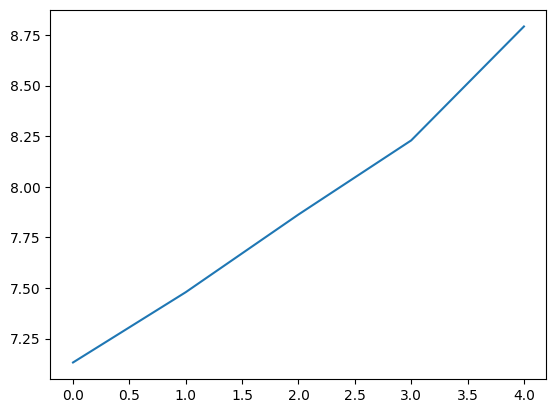

In [36]:
pd.Series(obj_list).plot()

In [37]:
I, K, a, p, epsilon, LB = make_data()
i = 0
epsilon = i * 0.01
model = prodmix(I, K, a, p, epsilon, LB)
model.solve(verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:36 PM: Your problem has 4 variables, 4 constraints, and 0 parameters.
(CVXPY) Nov 10 03:45:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 03:45:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:36 PM: Compiling problem (target solver=CLARABEL).
(

np.float64(7.131578929528664)

In [38]:
I, K, a, p, epsilon, LB = make_data()
i = 1
epsilon = i * 0.01
model = prodmix(I, K, a, p, epsilon, LB)
model.solve(verbose=True, solver=cp.SCIP)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 10 03:45:36 PM: Your problem has 7 variables, 7 constraints, and 0 parameters.
(CVXPY) Nov 10 03:45:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 03:45:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 03:45:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 10 03:45:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 03:45:36 PM: Compiling problem (target solver=SCIP).
(CVXP

np.float64(7.478949917873269)